# Basic burn probability benchmarking
This notebook compares our burn probability estimates with historical U.S. fire perimeter data as a general, surface-level benchmark of the burn probabilities. The benchmark tests are adapted from [Moran et al. 2025](https://www.nature.com/articles/s41598-025-07968-6), which applied similar methods to annually benchmark model-derived burn probability data from 2020-2023 over the state of California. The burn probability estimates from our dataset and Moran et al. (2025) are both derived from simulations from the Fsim modeling system [(Finney et al. 2011)](https://research.fs.usda.gov/treesearch/39312).

We focus on the present-day (the climate between 2005 and 2020) burn probability map (rather than the simulation for the future, 2040-2055 climate) and compare it to the 70+ year historical record of burn perimeters. This approach implicitly assumes that it is reasonable to use the 2011 map to evaluate a record largely within the 20th century. This assumption is tolerable because the 15 year period the present-day map is based upon is relatively comparable compared to the late 20th century.

The notebook here relies on pre-processing done in the [`benchmarking-process-inputs.ipynb`](./benchmarking-process-inputs.ipynb) and [`benchmarking-make-inputs.ipynb`](./benchmarking-make-inputs.ipybenchmarking-process-inputs.ipynb) notebooks.

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
# --- set up processed data cases
datpath = 's3://carbonplan-ocr/evaluation/benchmarking-processed/'
slc = {
    'testbox': {},
    'CONUS': {
        'df1a_expandFactor_all': 8e6,
        'df1a_expandFactor_NB': 6e6,
        'df1b_vmax_all': 0.001,
        'df1b_vmax_NB': 0.001,
    },
}

# ---------------------------------------------------------
# select the slice to plot
slicename = 'CONUS'
# ---------------------------------------------------------

# Bechmark 1a: BP of burned and non-burned pixels
Requires a lot of memory to do it the normal way. Instead, we lazily compute N bins and plot the resulting histogram bins in violin style (see `benchmarking_process_inputs.ipynb` for computation). We repeat it for all data and for just the "non-burnable" pixels of Riley et al.

In [4]:
# --- read in and process data
df1a = pd.read_parquet(os.path.join(datpath, f'{slicename}_maskdf.parquet'))

# ( set bp range )
bp_range = (
    0,
    0.14,
)  # max confirmed in `benchmarking_process_inputs.ipynb` with: bp.max(skipna=True).compute()


# compute median, mean, and cdf
def weighted_stats(bin_centers, weights):
    mean = np.sum(bin_centers * weights) / np.sum(weights)
    cdf = np.cumsum(weights) / np.sum(weights)
    median = np.interp(0.5, cdf, bin_centers)
    return mean, median, cdf


# [ ALL DATA ]
burned_mean, burned_median, burned_cdf = weighted_stats(
    df1a['bin_centers'], df1a['burned_BPdensity']
)
unburned_mean, unburned_median, unburned_cdf = weighted_stats(
    df1a['bin_centers'], df1a['unburned_BPdensity']
)
# [ UNBURNABLE ONLY ]
burned_mean_unburnable, burned_median_unburnable, burned_cdf_unburnable = weighted_stats(
    df1a['bin_centers'], df1a['burned_BPdensity_NB']
)
unburned_mean_unburnable, unburned_median_unburnable, unburned_cdf_unburnable = weighted_stats(
    df1a['bin_centers'], df1a['unburned_BPdensity_NB']
)

# replace zero density with nan (to avoid plotting zero density)
df1a['burned_BPdensity'] = df1a['burned_BPdensity'].replace(0, np.nan)
df1a['unburned_BPdensity'] = df1a['unburned_BPdensity'].replace(0, np.nan)
df1a['burned_BPdensity_NB'] = df1a['burned_BPdensity_NB'].replace(0, np.nan)
df1a['unburned_BPdensity_NB'] = df1a['unburned_BPdensity_NB'].replace(0, np.nan)

## Comparing burned probability in previously burned and unburned areas

Below we use the historical fire perimeters to divide the domain into regions which have burned and not burned. We then compare the burn probability in those two groups and find that the burned areas had a higher average burn probability in our dataset compared to the unburned areas. This indicates that we are correctly modeling elevated burn probability in those burned areas. These results are comparable to those in Moran et al. (2025). 

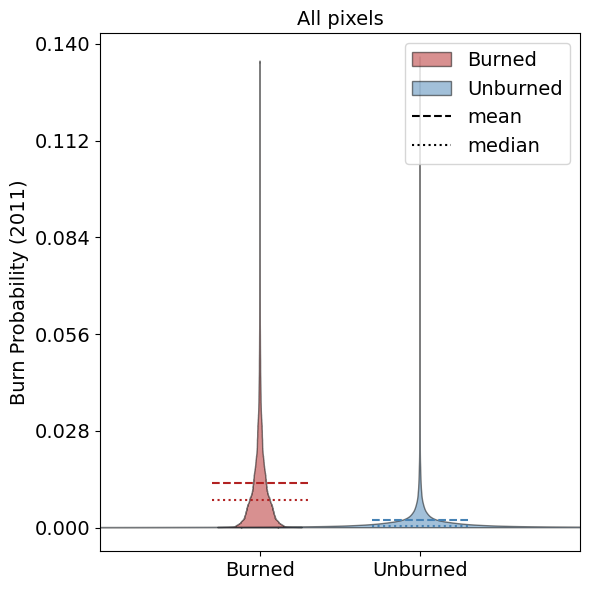

In [5]:
# [ ALL DATA ]
# --- aesthetics -------------
burncol = 'firebrick'
unburncol = 'steelblue'
edgecol = 'black'
fill_alph = 0.5
lwd_mean = 1.5
lwd_median = 1.5
fs_title = 14
fs_tick = 14
fs_axtitle = 14
fs_leg = 14
ls_mean = '--'
ls_median = ':'
line_buff = 0.3
# ----------------------------

# plot
fig, ax = plt.subplots(figsize=(6, 6))
width = (df1a['bin_centers'][1] - df1a['bin_centers'][0]) * slc[slicename].get(
    'df1a_expandFactor_all', 3e6
)

# violin shapes
ax.fill_betweenx(
    df1a['bin_centers'],
    -df1a['burned_BPdensity'] * width,
    df1a['burned_BPdensity'] * width,
    edgecolor=edgecol,
    facecolor=burncol,
    alpha=fill_alph,
    label='Burned',
)
ax.fill_betweenx(
    df1a['bin_centers'],
    1 - df1a['unburned_BPdensity'] * width,
    1 + df1a['unburned_BPdensity'] * width,
    edgecolor=edgecol,
    facecolor=unburncol,
    alpha=fill_alph,
    label='Unburned',
)

# mean and median lines
ax.plot(
    [-line_buff, line_buff],
    [burned_mean, burned_mean],
    color=burncol,
    linestyle=ls_mean,
    linewidth=lwd_mean,
)
ax.plot(
    [-line_buff, line_buff],
    [burned_median, burned_median],
    color=burncol,
    linestyle=ls_median,
    linewidth=lwd_median,
)
ax.plot(
    [-line_buff + 1, line_buff + 1],
    [unburned_mean, unburned_mean],
    color=unburncol,
    linestyle=ls_mean,
    linewidth=lwd_mean,
)
ax.plot(
    [-line_buff + 1, line_buff + 1],
    [unburned_median, unburned_median],
    color=unburncol,
    linestyle=ls_median,
    linewidth=lwd_median,
)
# (lines for label only)
ax.plot([0, 0], [0, 0], color='black', linestyle=ls_mean, linewidth=lwd_mean, label='mean')
ax.plot([0, 0], [0, 0], color='black', linestyle=ls_median, linewidth=lwd_median, label='median')

# labels and formatting
ax.tick_params(axis='both', labelsize=fs_tick)
ax.set_yticks(np.linspace(bp_range[0], bp_range[1], 6))
ax.set_ylabel('Burn Probability (2011)', fontsize=fs_axtitle)
ax.set_xticks([0, 1])
ax.set_xticklabels(['Burned', 'Unburned'])
ax.set_xlim(-1, 2)
ax.legend(fontsize=fs_leg, loc='upper right')
plt.title('All pixels', fontsize=fs_title)
plt.tight_layout()

plt.show()
plt.close()

## Assess performance in non-burnable areas

Our approach retains the results of Riley et al. (2025) anywhere their modeling set-up defined as "burnable" which generally included wildlands and excluded developed areas. Our focus was in developing risk estimates for developed areas, and thus we extended burn probability into the regions deemed "non-burnable" by Riley et al. (2025). We repeat the analysis above but exclusively for these regions to evaluate exclusively the estimates we created. As in above, our estimates assign higher burn probabilities to areas that have historically burned than areas that have not historically burned.

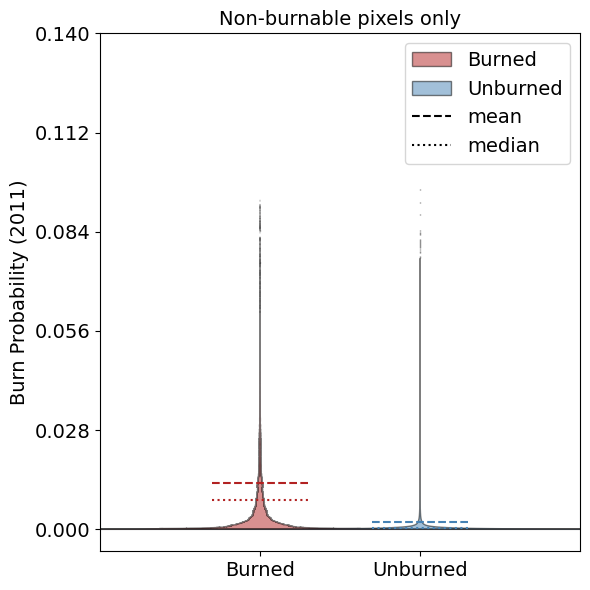

In [7]:
# [ NON-BURNABLE ONLY ]
# --- aesthetics -------------
burncol = 'firebrick'
unburncol = 'steelblue'
edgecol = 'black'
fill_alph = 0.5
lwd_mean = 1.5
lwd_median = 1.5
fs_title = 14
fs_tick = 14
fs_axtitle = 14
fs_leg = 14
ls_mean = '--'
ls_median = ':'
line_buff = 0.3
# ----------------------------

# plot
fig, ax = plt.subplots(figsize=(6, 6))
width = (df1a['bin_centers'][1] - df1a['bin_centers'][0]) * slc[slicename].get(
    'df1a_expandFactor_NB', 3e6
)

# violin shapes
ax.fill_betweenx(
    df1a['bin_centers'],
    -df1a['burned_BPdensity_NB'] * width,
    df1a['burned_BPdensity_NB'] * width,
    edgecolor=edgecol,
    facecolor=burncol,
    alpha=fill_alph,
    label='Burned',
)
ax.fill_betweenx(
    df1a['bin_centers'],
    1 - df1a['unburned_BPdensity_NB'] * width,
    1 + df1a['unburned_BPdensity_NB'] * width,
    edgecolor=edgecol,
    facecolor=unburncol,
    alpha=fill_alph,
    label='Unburned',
)

# mean and median lines
ax.plot(
    [-line_buff, line_buff],
    [burned_mean, burned_mean],
    color=burncol,
    linestyle=ls_mean,
    linewidth=lwd_mean,
)
ax.plot(
    [-line_buff, line_buff],
    [burned_median, burned_median],
    color=burncol,
    linestyle=ls_median,
    linewidth=lwd_median,
)
ax.plot(
    [-line_buff + 1, line_buff + 1],
    [unburned_mean, unburned_mean],
    color=unburncol,
    linestyle=ls_mean,
    linewidth=lwd_mean,
)
ax.plot(
    [-line_buff + 1, line_buff + 1],
    [unburned_median, unburned_median],
    color=unburncol,
    linestyle=ls_median,
    linewidth=lwd_median,
)
# (lines for label only)
ax.plot([0, 0], [0, 0], color='black', linestyle=ls_mean, linewidth=lwd_mean, label='mean')
ax.plot([0, 0], [0, 0], color='black', linestyle=ls_median, linewidth=lwd_median, label='median')

# labels and formatting
ax.tick_params(axis='both', labelsize=fs_tick)
ax.set_yticks(np.linspace(bp_range[0], bp_range[1], 6))
ax.set_ylabel('Burn Probability (2011)', fontsize=fs_axtitle)
ax.set_xticks([0, 1])
ax.set_xticklabels(['Burned', 'Unburned'])
ax.set_xlim(-1, 2)
ax.legend(fontsize=fs_leg, loc='upper right')
plt.title('Non-burnable pixels only', fontsize=fs_title)
plt.tight_layout()

plt.show()
plt.close()